### Required Libraries and Utilities

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from scipy.stats import randint

from imblearn.over_sampling import SMOTE
from collections import Counter

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
def Generate_Model_Test_Classification_Report(model, X_test, y_test, model_name=""):
            y = 1.05

            fig, axes = plt.subplots(3, 1, figsize = (8, 3))
            axes[0].text(9, 1.8, "CONSOLIDATED MODEL TEST REPORT", fontsize=30, horizontalalignment='center',
                        color='DarkBlue', weight = 'bold')

            axes[0].axis([0, 10, 0, 10])
            axes[0].axis('off')

            axes[1].text(9, 4, "Model Name: " + model_name, style='italic',
                                fontsize=18, horizontalalignment='center', color='DarkOrange', weight = 'bold')

            axes[1].axis([0, 10, 0, 10])
            axes[1].axis('off')

            axes[2].text(0, 4, "* 1 - Not Survived\t\t\t\t\t\t\t * 0 - Survived\n".expandtabs() +
                        "* MCC - Matthews Correlation Coefficient\t\t* AUC - Area Under The Curve\n".expandtabs() +
                        "* ROC - Receiver Operating Characteristics     " +
                        "\t* AUROC - Area Under the Receiver Operating    Characteristics".expandtabs(),
                        style='italic', fontsize=10, horizontalalignment='left', color='orangered')

            axes[2].axis([0, 10, 0, 10])
            axes[2].axis('off')

            scores = []
            metrics = ['F1       ', 'MCC      ', 'Precision', 'Recall   ', 'Accuracy ',
                      'AUC_ROC  ', 'AUC_PR   ']

            y_pred = model.predict(X_test)
            y_pred_probs = model.predict_proba(X_test)[:, 1:]

            fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_pred)
            precision, recall, th = precision_recall_curve(y_test.values.ravel(), y_pred_probs)

            model_f1_score = f1_score(y_test, y_pred)
            model_matthews_corrcoef_score = matthews_corrcoef(y_test, y_pred)
            model_precision_score = precision_score(y_test, y_pred)
            model_recall_score = recall_score(y_test, y_pred)
            model_accuracy_score = accuracy_score(y_test, y_pred)
            model_auc_roc = auc(fpr, tpr)
            model_auc_pr = auc(recall, precision)

            scores.append([model_f1_score,
                          model_matthews_corrcoef_score,
                          model_precision_score,
                          model_recall_score,
                          model_accuracy_score,
                          model_auc_roc,
                          model_auc_pr])

            sampling_results = pd.DataFrame(columns = ['Classification Metric', 'Score Value'])
            for i in range(len(scores[0])):
                sampling_results.loc[i] = [metrics[i], scores[0][i]]

            sampling_results.index = np.arange(1, len(sampling_results) + 1)

            class_report = classification_report(y_test, y_pred)
            conf_matx = confusion_matrix(y_test, y_pred)

            fig, axes = plt.subplots(1, 3, figsize = (20, 4))         # Display the Confusion Matrix
            sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
            axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold',
                              style='italic', loc='left', y=y)

            axes[1].text(5, 1.8, sampling_results.to_string(float_format='{:,.4f}'.format, index=False), style='italic',          # Classification Metrics
                        fontsize=20, horizontalalignment='center')
            axes[1].axis([0, 10, 0, 10])
            axes[1].axis('off')
            axes[1].set_title("2. Classification Metrics", fontsize=20, color='darkgreen', weight = 'bold',
                              style='italic', loc='center', y=y)

            axes[2].text(0, 1, class_report, style='italic', fontsize=20)   # Classification Report
            axes[2].axis([0, 10, 0, 10])
            axes[2].axis('off')
            axes[2].set_title("3. Classification Report", fontsize=20, color='darkgreen', weight = 'bold',
                              style='italic', loc='center', y=y)

            plt.tight_layout()
            plt.show()

            fig, axes = plt.subplots(1, 2, figsize = (14, 4))         # AUC-ROC & Precision-Recall Curve

            axes[0].plot(fpr, tpr, label = f"auc_roc = {model_auc_roc:.3f}")
            axes[1].plot(recall, precision, label = f"auc_pr = {model_auc_pr:.3f}")

            axes[0].plot([0, 1], [0, 1], 'k--')
            axes[0].legend(loc = "lower right")
            axes[0].set_xlabel("False Positive Rate")
            axes[0].set_ylabel("True Positive Rate")
            axes[0].set_title("4. AUC - ROC Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold',
                              style='italic', loc='center', pad=1, y=y)

            axes[1].legend(loc = "lower left")
            axes[1].set_xlabel("Recall")
            axes[1].set_ylabel("Precision")
            axes[1].set_title("5. Precision - Recall Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold',
                              style='italic', loc='center', pad=3, y=y)

            plt.subplots_adjust(top=0.95)
            plt.tight_layout()
            plt.show()

            return None

### Set Notebook Configuration Parameters

### Utility Functions

### Import Data

In [3]:
heart_faliure_data = pd.read_csv(filepath_or_buffer = '/content/drive/MyDrive/heart_failure_clinical_records_data.csv',
                                 low_memory = False,
                                 skipinitialspace = True,
                                 float_precision = 'round_trip')

heart_faliure_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
heart_faliure_data.shape

(299, 13)

In [6]:
# Check the total missing values in each column.
print("Total NULL Values in each columns")
print("*********************************")
print(heart_faliure_data.isnull().sum())

Total NULL Values in each columns
*********************************
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


***This looks to be a clean dataset without any missing values...***

In [7]:
heart_faliure_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


## Data Preparation

### Test - Train Split

In [8]:
X = heart_faliure_data[['ejection_fraction', 'serum_creatinine', 'age']]
y = heart_faliure_data[['DEATH_EVENT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, test_size = 0.10, random_state = 109)

print("X_Train Shape:", X_train.shape)
print("Y_Train Shape:", y_train.shape)
print("X_Test Shape:", X_test.shape)
print("Y_Test Shape:", y_test.shape)

X_Train Shape: (269, 3)
Y_Train Shape: (269, 1)
X_Test Shape: (30, 3)
Y_Test Shape: (30, 1)


#### Data Value Counts

In [9]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

Original dataset shape Counter({0: 186, 1: 83})


#### <font color = brown>Data Insight 17:</font>

**`1. As we see in the training data, the number of 1s (83 - Death Event) are much less comapred to the number of 0s (171 - Survival Case). This is also confirmed in the Data Insight 15.`**

**`2. With this imbalance dataset (67.89% survival cases & 32.11% death events), the model could become more inclined towards learnign and predicting the negative examples than the positive (death) cases.`**

**`3. To avoid this scenario and create an un-biased model, the dataset should be balanced where we need to generate more  examples of the minority class. We will apply the Synthetic Minority Oversampling Technique (SMOTE) algorithm on the training data such that more examples of the death events are generated and we have a balanced dataset.`**

In [10]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

Original dataset shape Counter({0: 186, 1: 83})


In [11]:
data_features = dict(enumerate(X.columns))
data_features

{0: 'ejection_fraction', 1: 'serum_creatinine', 2: 'age'}

#### Synthetic Minority Oversampling Technique (SMOTE)

In [12]:
# Implement SMOTE
sampling = SMOTE(random_state = 100)
X_train, y_train = sampling.fit_resample(X_train.values, y_train.values.ravel())

# Shuffle the data
perms = np.random.permutation(X_train.shape[0])
X_train = X_train[perms]
y_train = y_train[perms]

X_train = pd.DataFrame(data = X_train)
y_train = pd.DataFrame(data = y_train)

print(X_train.shape)
print(y_train.shape)

(372, 3)
(372, 1)


In [13]:
print('Resampled dataset shape %s' % Counter(y_train.values.ravel()))
print('Test dataset shape %s' % Counter(y_test.values.ravel()))

Resampled dataset shape Counter({1: 186, 0: 186})
Test dataset shape Counter({0: 17, 1: 13})


### Data Normalization

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## Model Building & Training

To predict patients survival due to heart failure, we will train models from different machine learning algorithms. The classifiers to be used in this study will be -

**`1. Support Vector Machines with RBF kernel`**

**`2. Decision Tree`**

**`3. Random Forest`**

**`4. Gradient Boosting - XGBoost`**

**`5. Light GBM`**

## 1. Support Vector Machines with RBF kernel

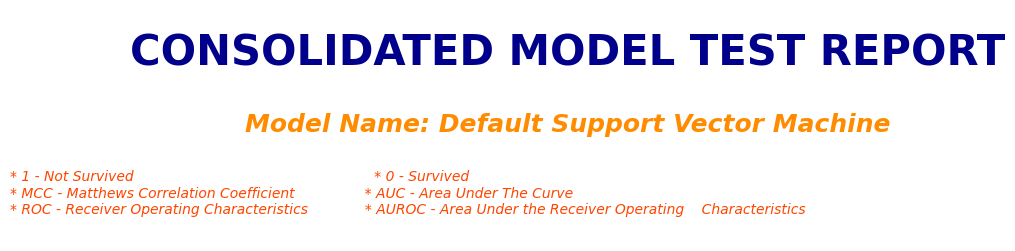

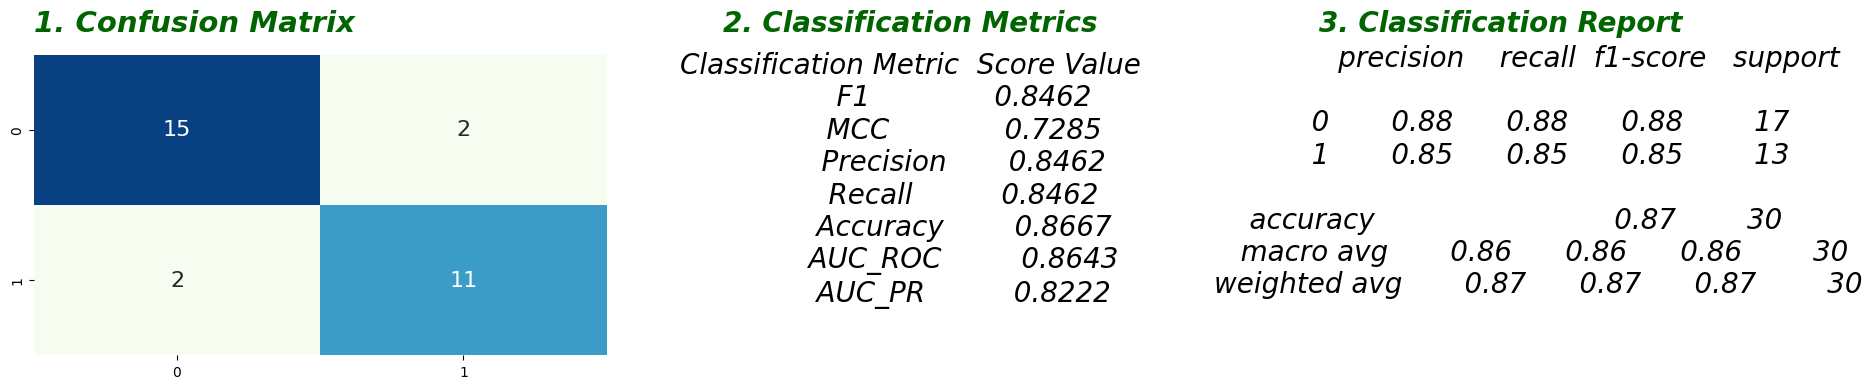

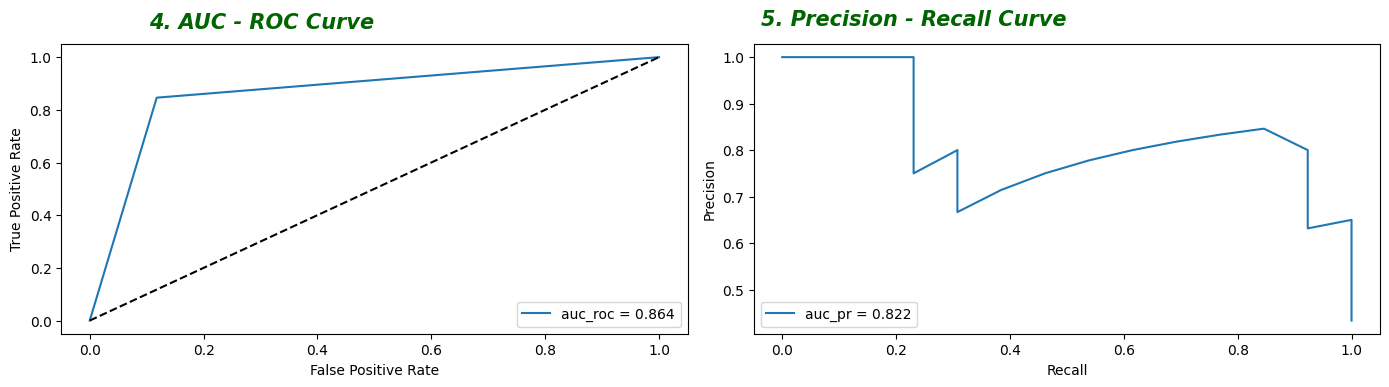

In [15]:
# SVM with Default Parameters and probability = True

svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

svm = svm.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(svm, X_test, y_test, model_name="Default Support Vector Machine")

### SVM Hyperparameters Tuning

In [16]:
# GridSearchCV to find best parameters for svm
svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

# parameters to build the model on
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_search = GridSearchCV(estimator = svm, param_grid = param_grid,
                  scoring = 'accuracy', n_jobs = -1, cv = 5, verbose = 2)

# fitting the model for grid search
grid_search.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", grid_search.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", grid_search.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 100, 'gamma': 0.1}

Best Classifier: SVC(C=100, gamma=0.1, probability=True, random_state=100)


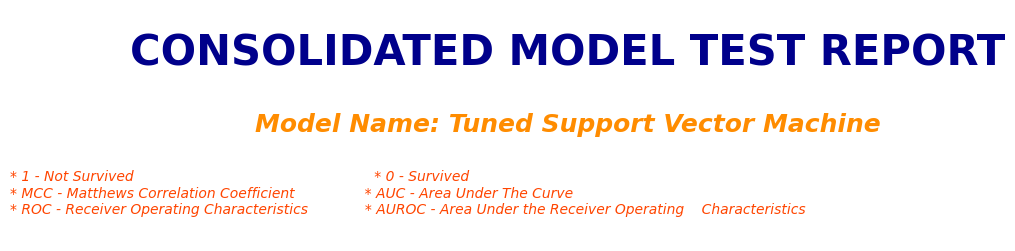

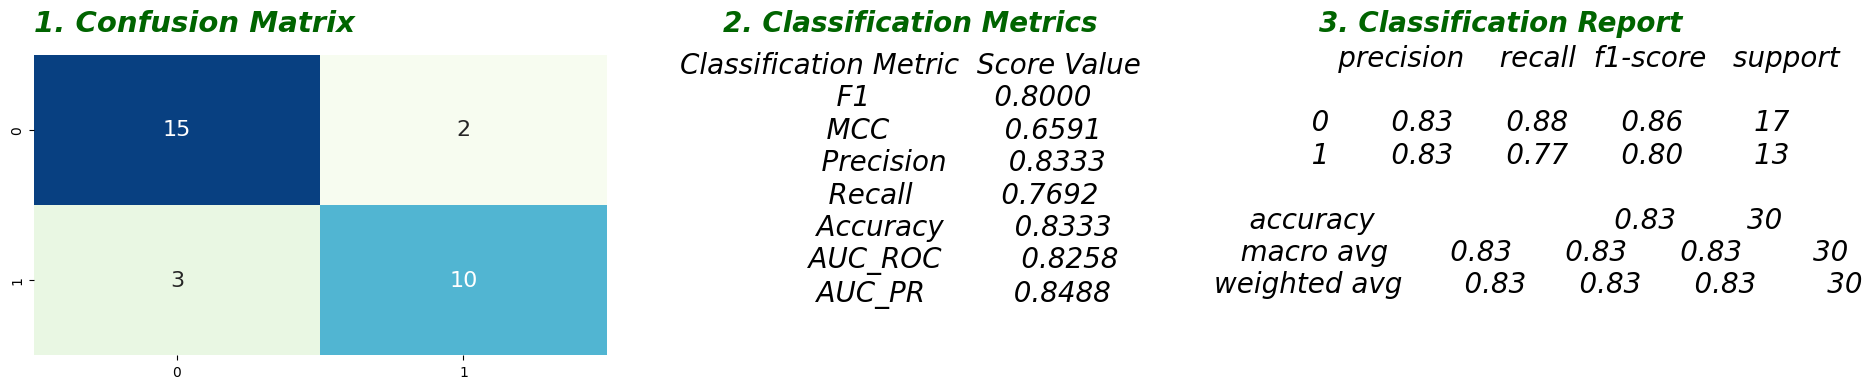

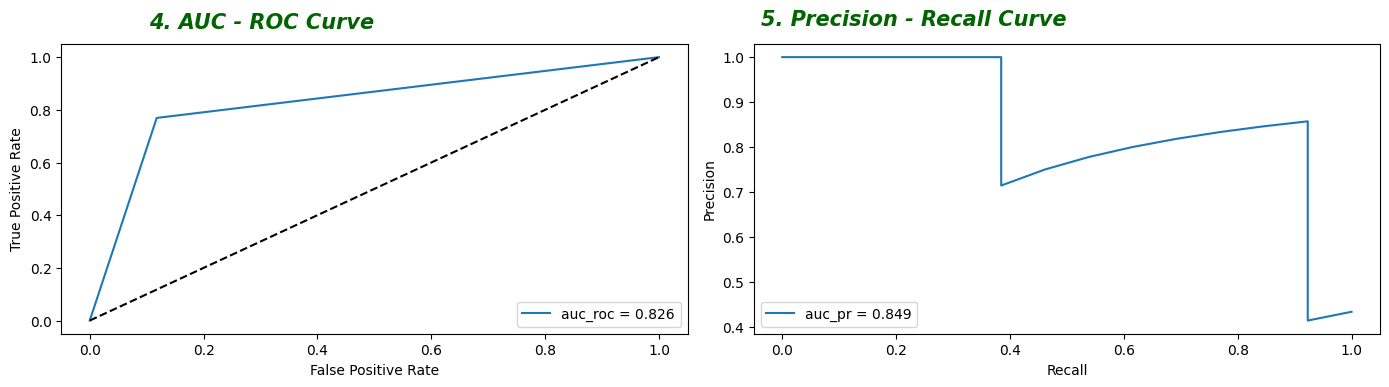

In [17]:
best_svc = grid_search.best_estimator_

best_svc.fit(X_train, y_train.values.ravel())


# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_svc, X_test, y_test, model_name="Tuned Support Vector Machine")

## 2. Decision Tree

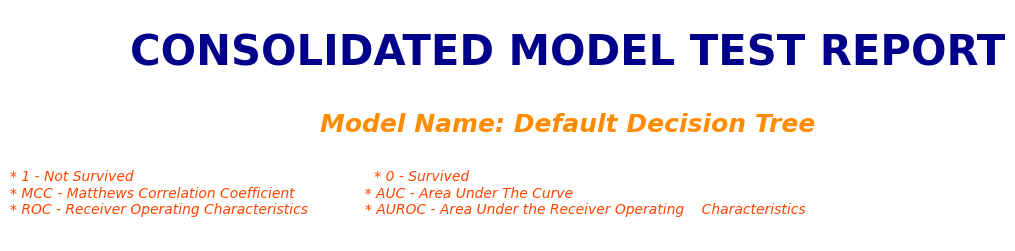

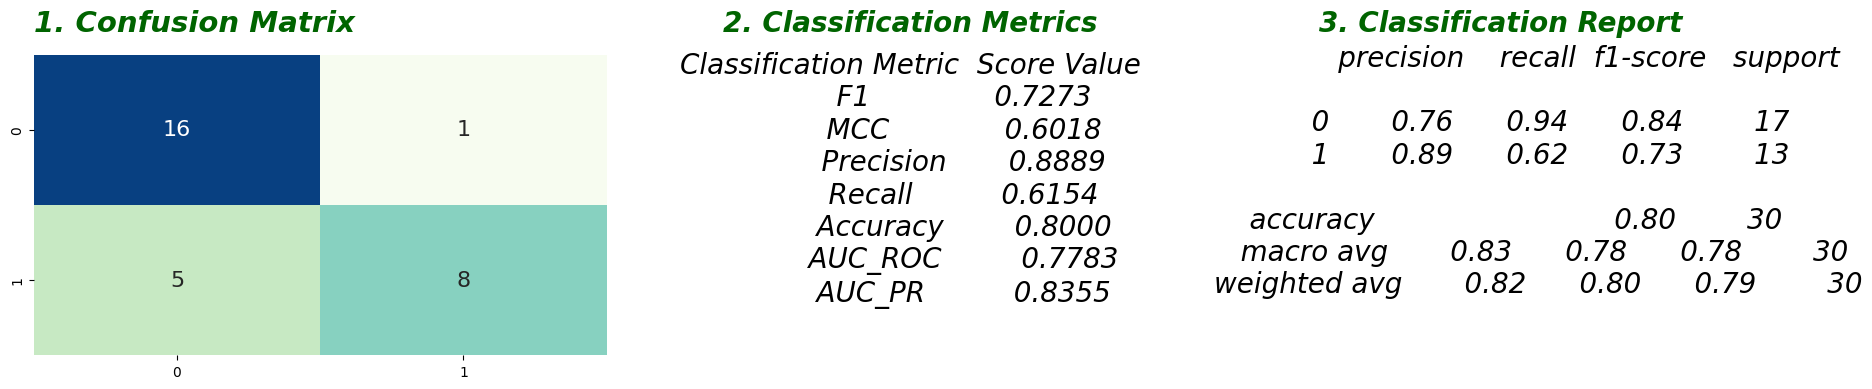

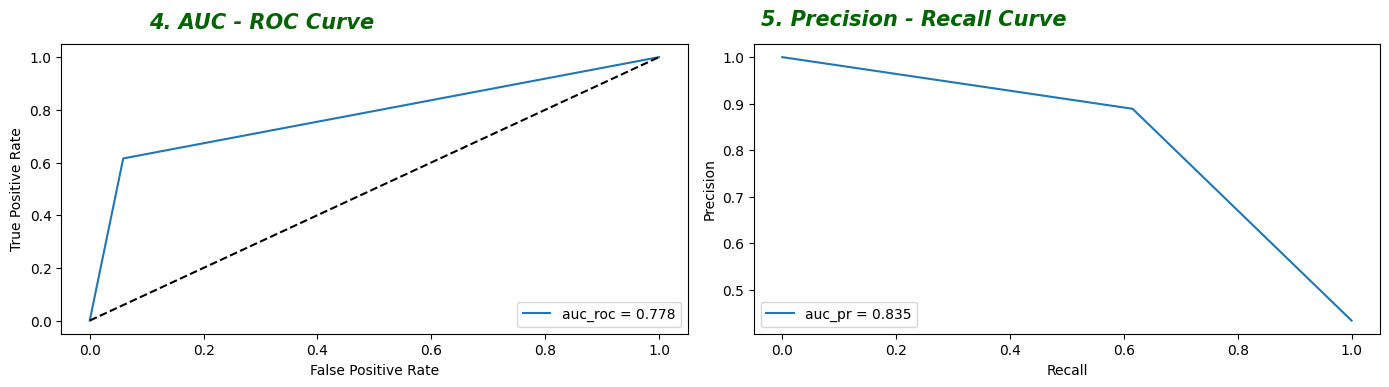

In [18]:
# Decision Tree with Default Parameters

tree = DecisionTreeClassifier(random_state = 100)

tree = tree.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(tree, X_test, y_test, model_name="Default Decision Tree")

### Decision Tree Hyperparameters Tuning

In [19]:
# GridSearchCV to find the optimal tree parameters
tree = DecisionTreeClassifier(random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 30),
#               "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "min_samples_split":range(2, 10),
              "criterion": ["gini", "entropy"]}

# Instantiating RandomizedSearchCV object
tree_grid = RandomizedSearchCV(tree, param_grid, cv = 5)

# fitting the model for grid search
tree_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", tree_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", tree_grid.best_estimator_)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5}

Best Classifier: DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                       random_state=100)


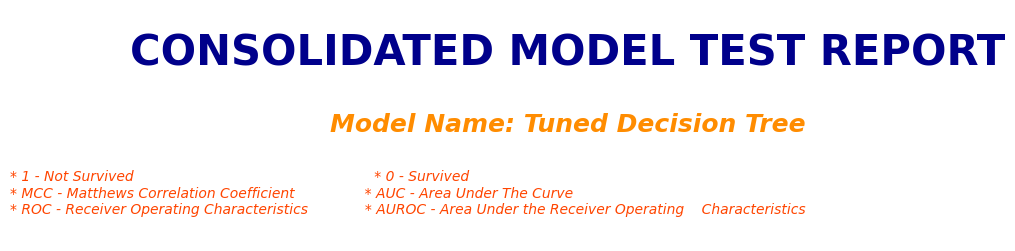

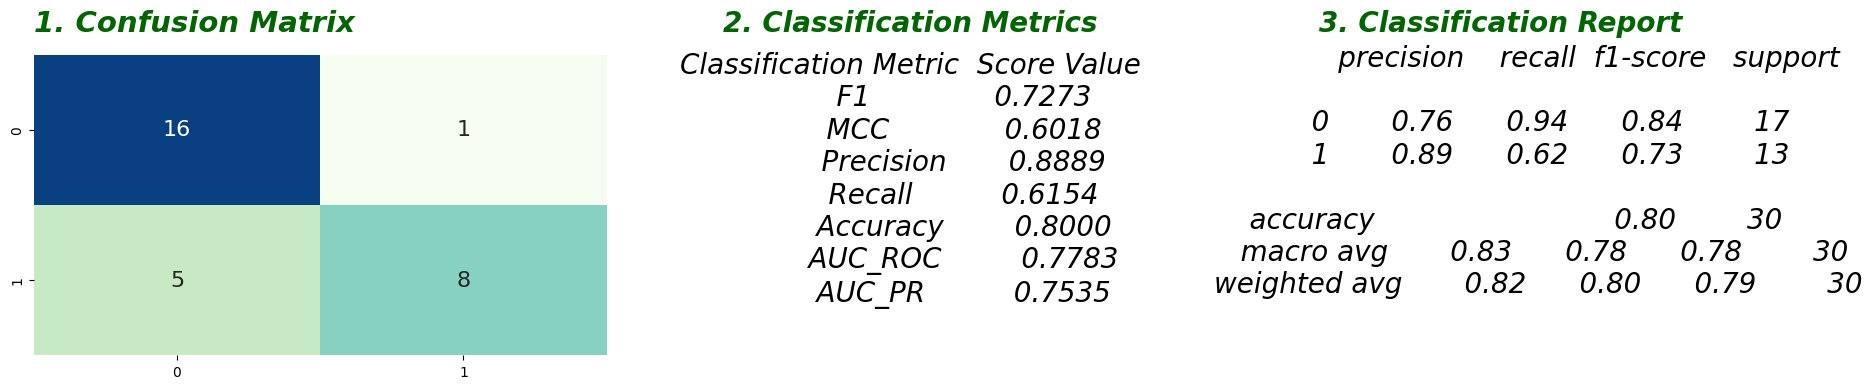

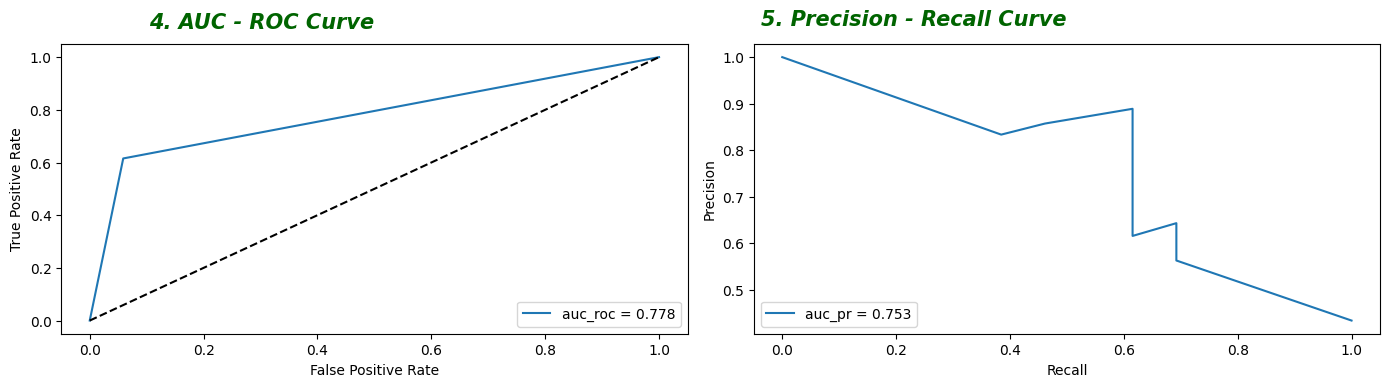

In [20]:
best_tree = tree_grid.best_estimator_

best_tree = best_tree.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_tree, X_test, y_test, model_name="Tuned Decision Tree")

## 3. Random Forest

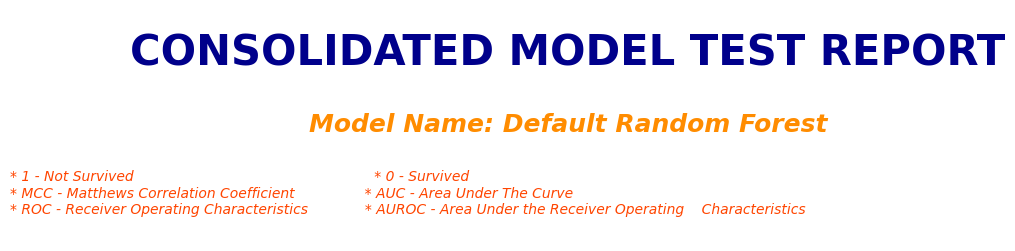

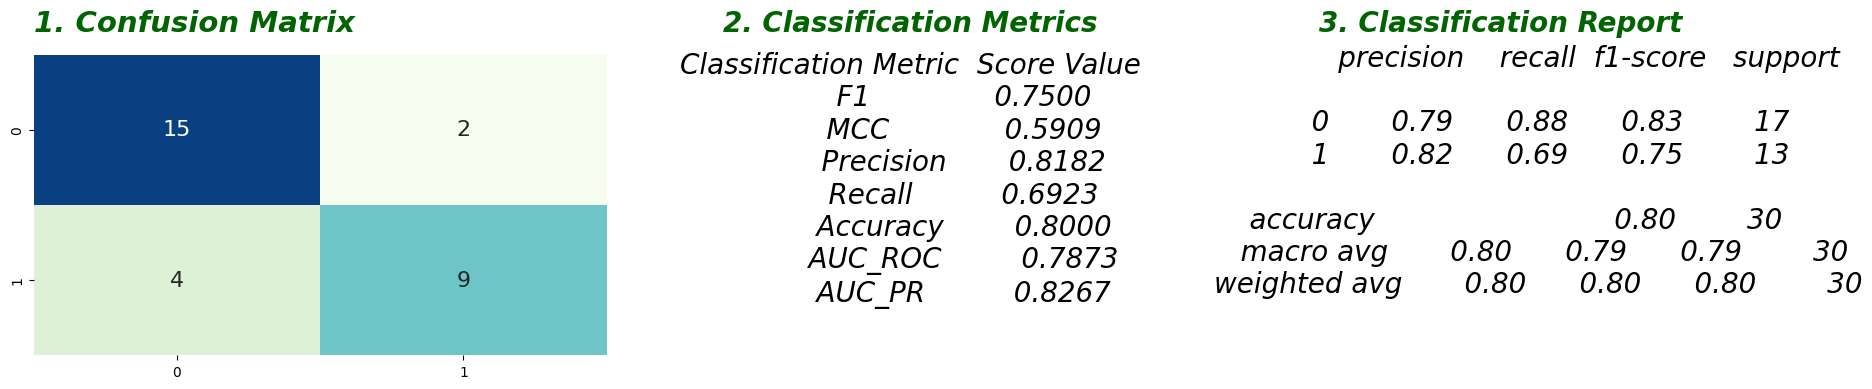

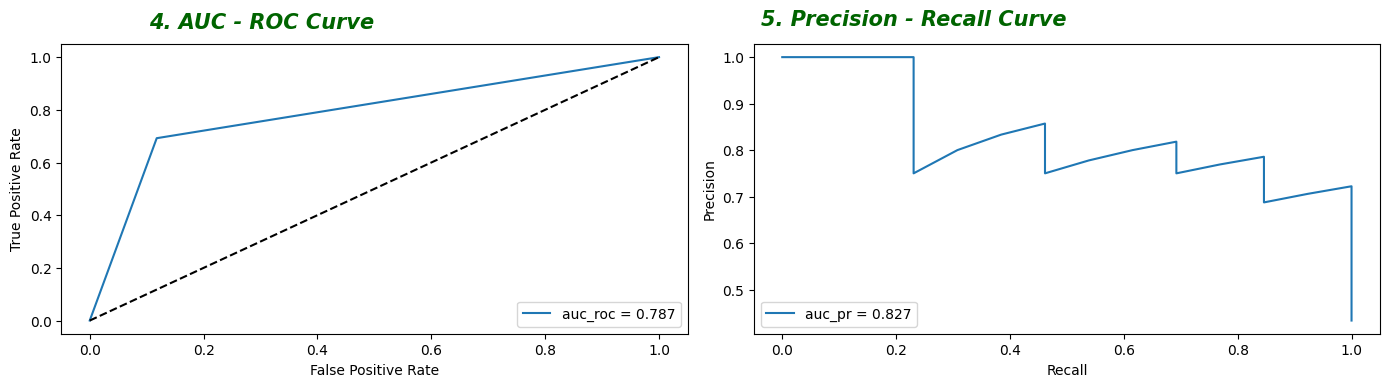

In [21]:
# Random Forest with Default Parameters
rfc = RandomForestClassifier(n_jobs = -1, random_state = 100)

rfc = rfc.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(rfc, X_test, y_test, model_name="Default Random Forest")

### Random Forest Hyperparameters Tuning

In [22]:
rn_forest = RandomForestClassifier(n_jobs = -1, random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 10),
#               "max_features": randint(1, 3),
              "min_samples_leaf": randint(25, 50),
              "min_samples_split":range(50, 100, 2),
              "n_estimators": range(1000, 8000, 500),
              "bootstrap": [True, False]}

# Instantiating RandomizedSearchCV object
forest_grid = RandomizedSearchCV(rn_forest, param_grid, cv = 5)

# fitting the model for grid search
forest_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", forest_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", forest_grid.best_estimator_)

Best Parameters: {'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 40, 'min_samples_split': 90, 'n_estimators': 1000}

Best Classifier: RandomForestClassifier(bootstrap=False, max_depth=2, min_samples_leaf=40,
                       min_samples_split=90, n_estimators=1000, n_jobs=-1,
                       random_state=100)


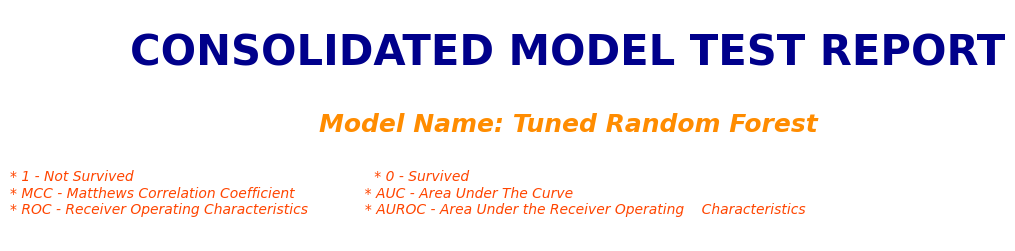

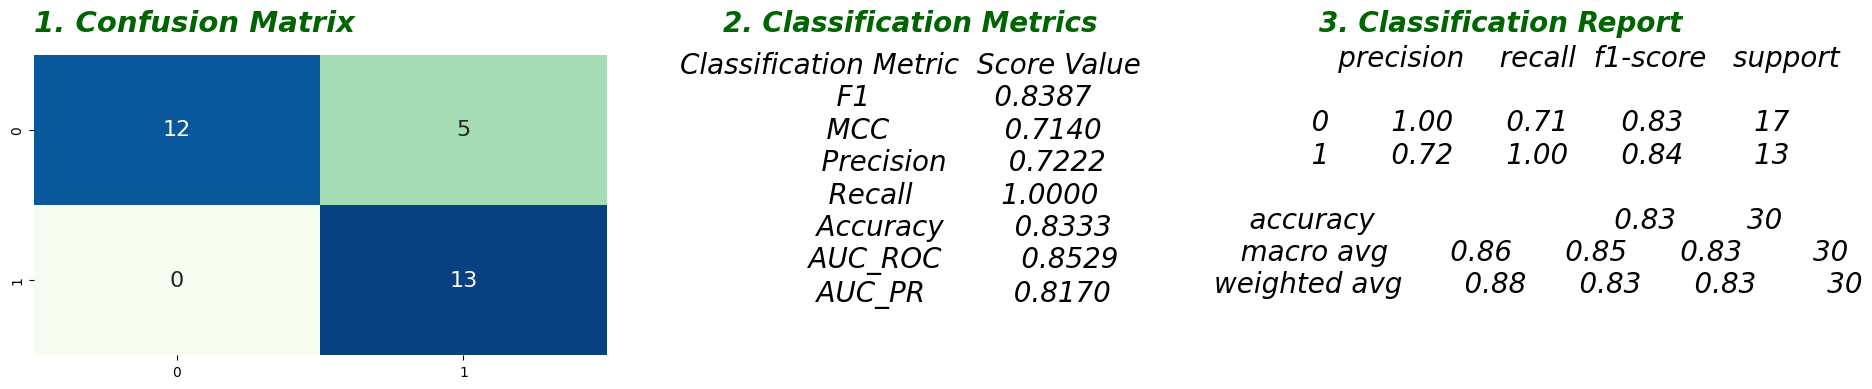

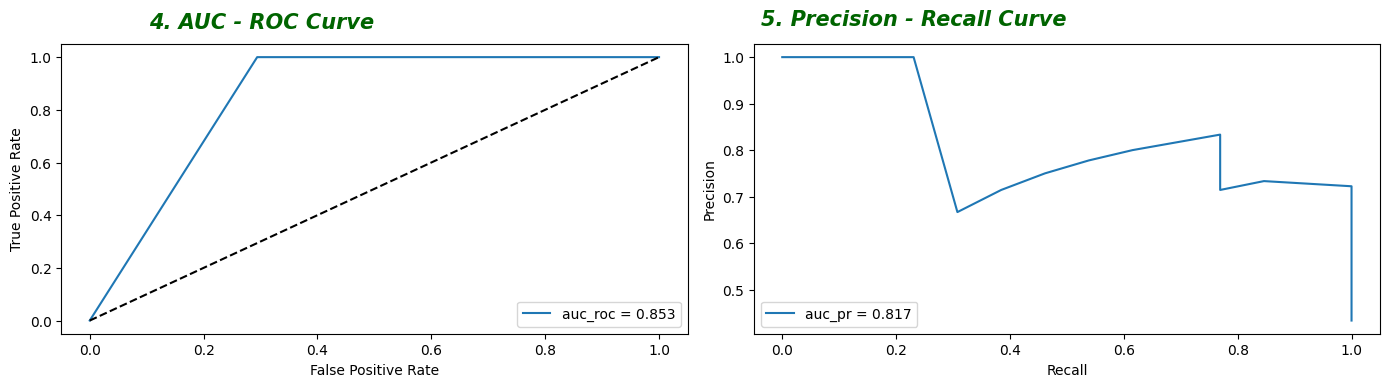

In [23]:
# Random Forest with Best Hypertuned Parameters
best_forest = forest_grid.best_estimator_

best_forest = best_forest.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_forest, X_test, y_test, model_name="Tuned Random Forest")

## 4. Extreme Gradient Boosting - XGBoost

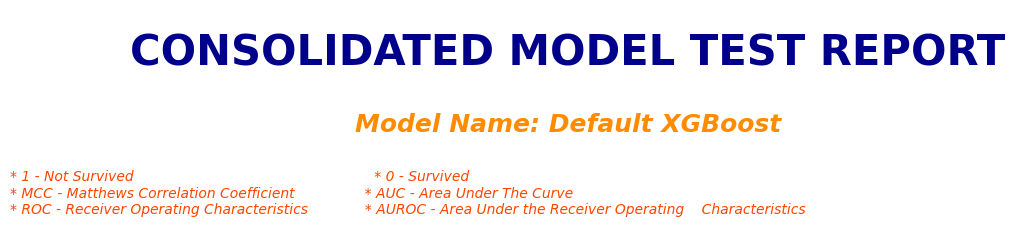

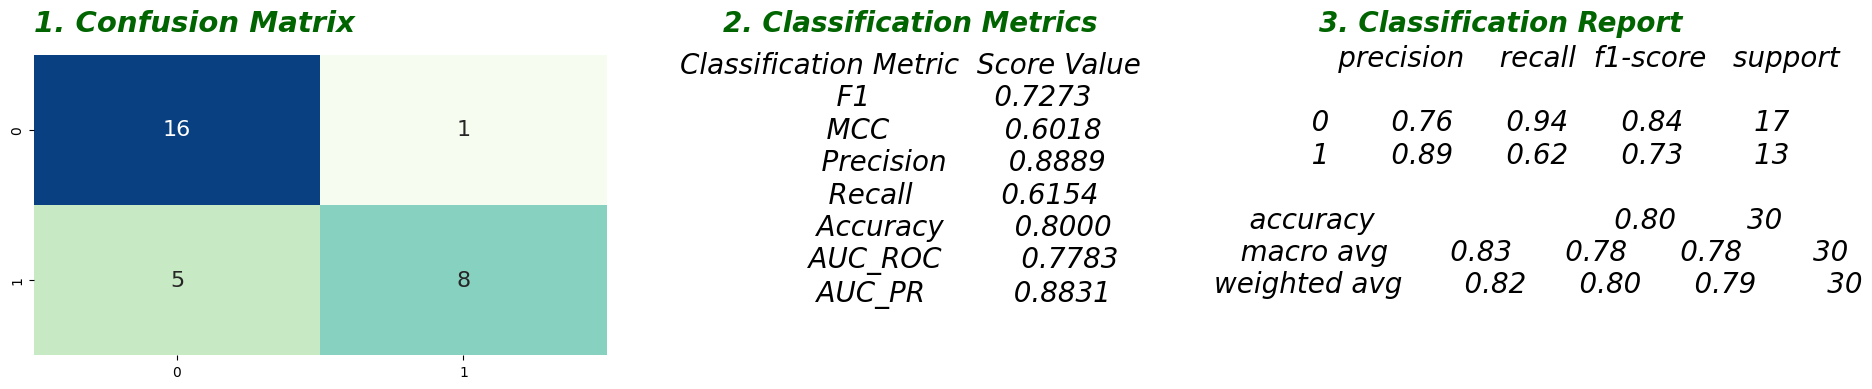

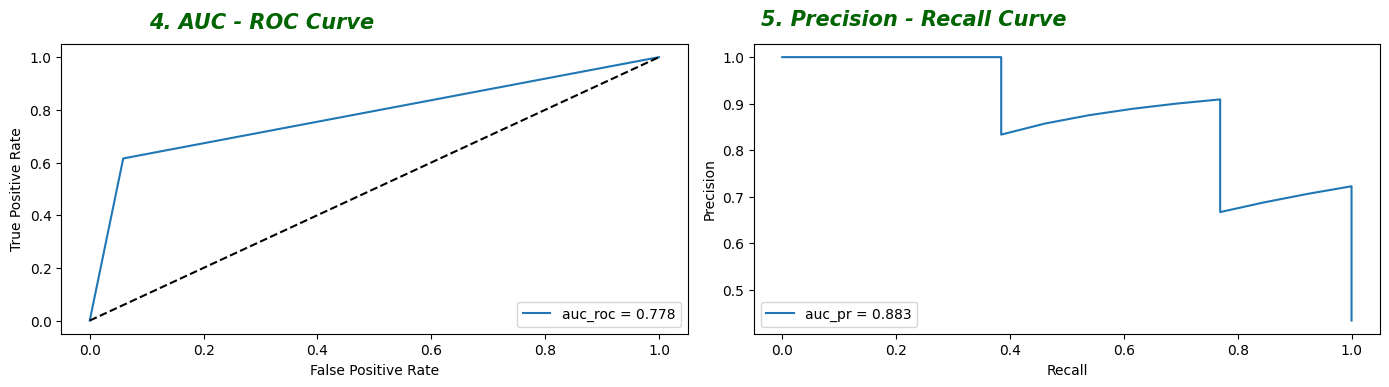

In [24]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

xgb = xgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(xgb, X_test, y_test, model_name="Default XGBoost")

In [25]:
# utils.plot_model_feature_importances(X_train, model = xgb)
xgb.feature_importances_

array([0.38019857, 0.36328527, 0.25651616], dtype=float32)

### XG Boost Hyperparameters Tuning

In [26]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.6, 0.9, 0.95, 0.99],
             'n_estimators': range(100, 1100, 100),
             'min_child_weight': range(1, 11),
             'subsample': np.arange(0.1, 1.1, 0.1),
             'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object
xgb_grid = RandomizedSearchCV(xgb, param_grid, cv = 5)

# fitting the model for grid search
xgb_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", xgb_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", xgb_grid.best_estimator_)

Best Parameters: {'subsample': 0.6, 'n_estimators': 600, 'min_child_weight': 6, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.4}

Best Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...)


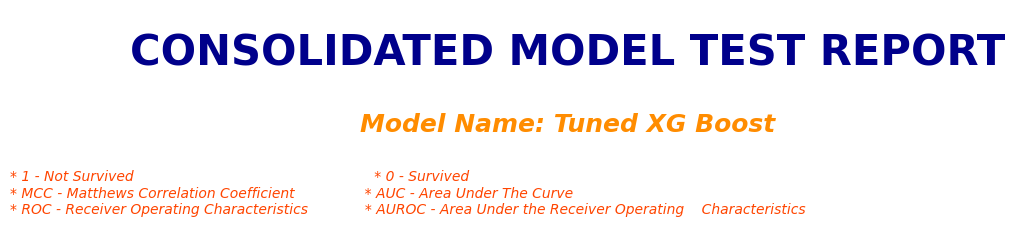

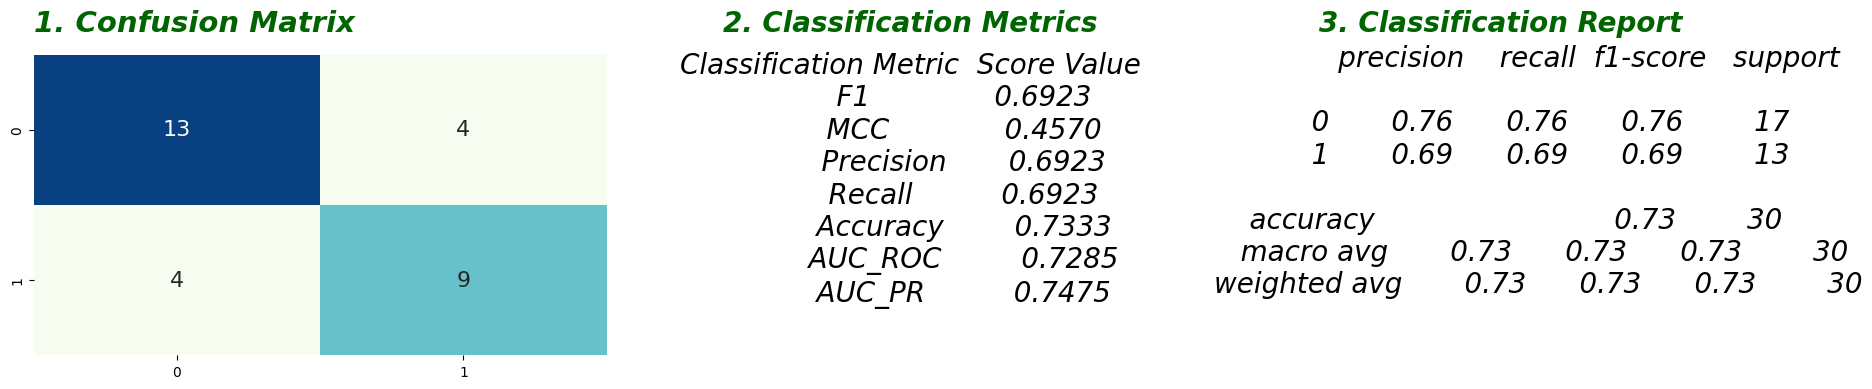

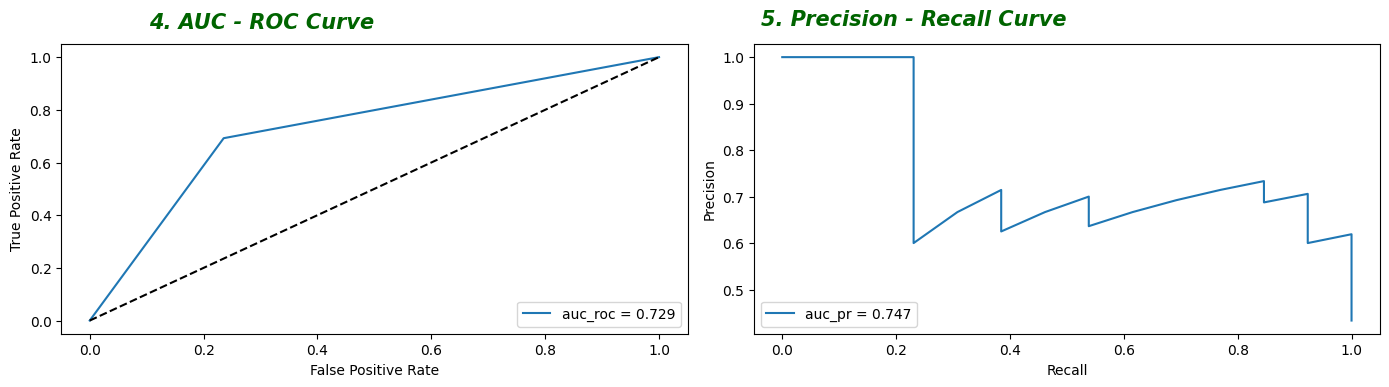

In [27]:
# XG Boost with Best Hypertuned Parameters
best_xgb = xgb_grid.best_estimator_

best_xgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_xgb, X_test, y_test, model_name="Tuned XG Boost")

## 5. Light Gradient Boosted Machine (Light GBM)

[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

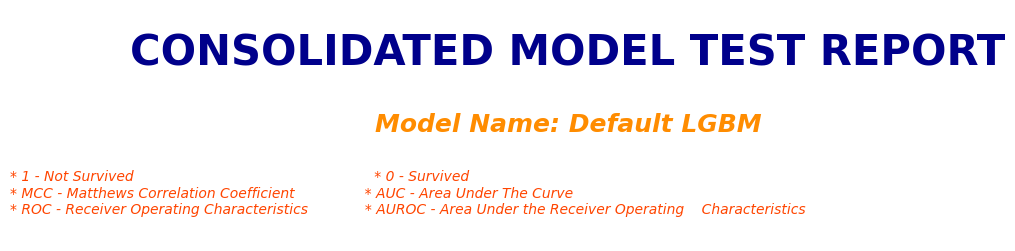

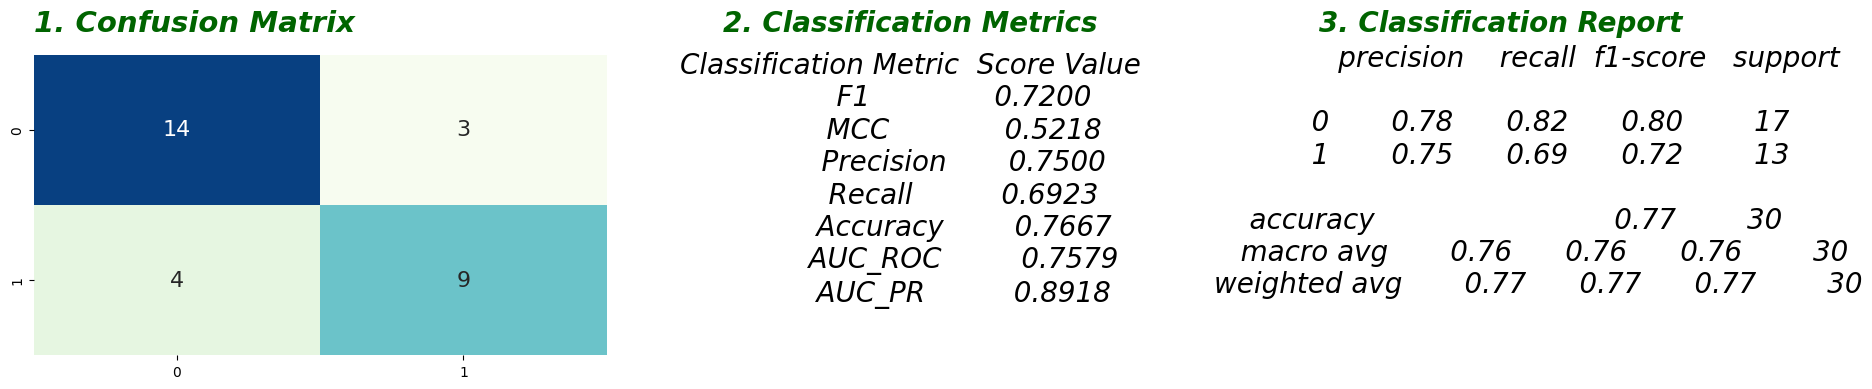

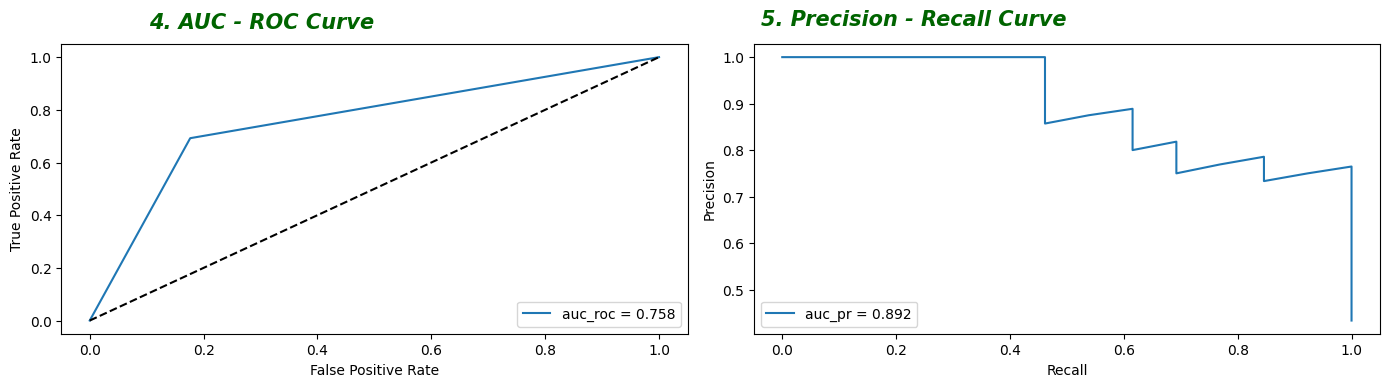

In [28]:
# LightGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

lgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(lgb, X_test, y_test, model_name="Default LGBM")

### LGBM Hyperparameter Tuning

In [29]:
# LGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
              'num_leaves': range(20, 100),
              'learning_rate': np.arange(0.1, 1.0, 0.1),
              'n_estimators': range(100, 1100, 100),
              'min_child_samples': range(1, 72),
              'subsample': np.arange(0.1, 1.1, 0.1),
              'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object
lgb_grid= RandomizedSearchCV(lgb, param_grid, cv = 5)

# fitting the model for grid search
lgb_grid = lgb_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", lgb_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", lgb_grid.best_estimator_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

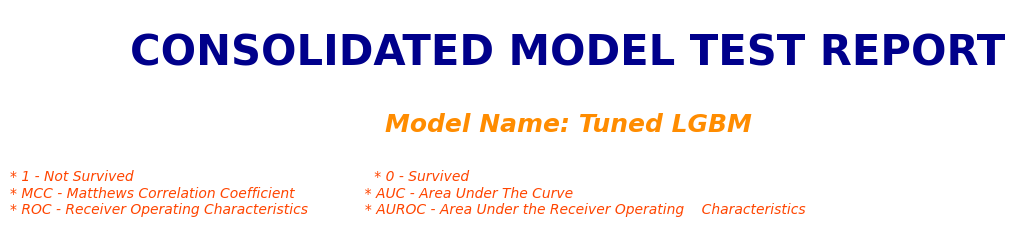

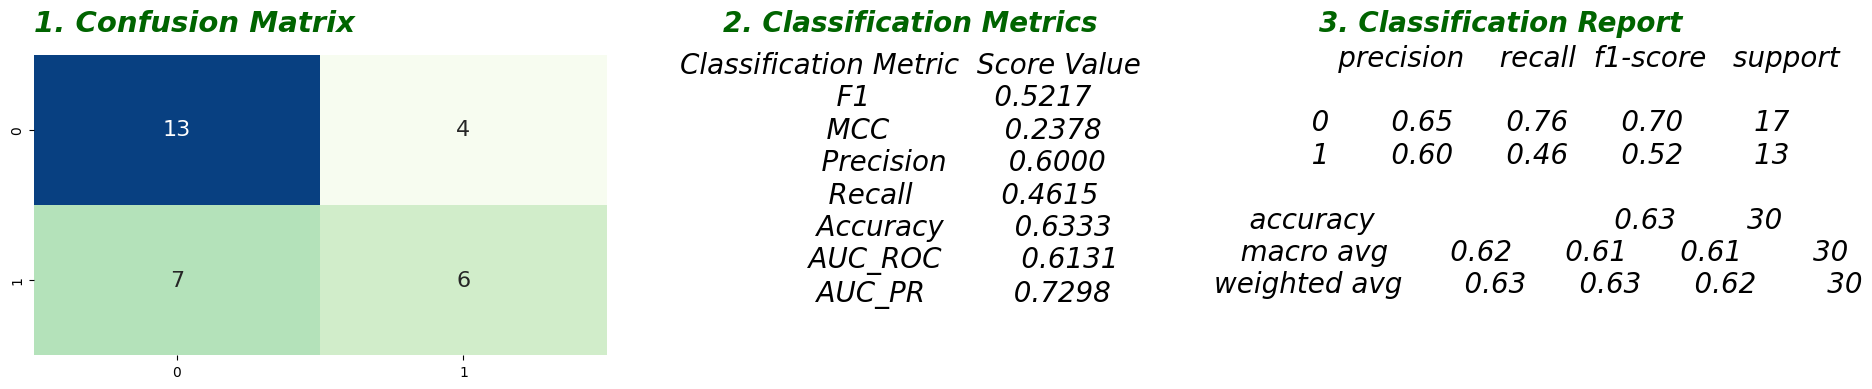

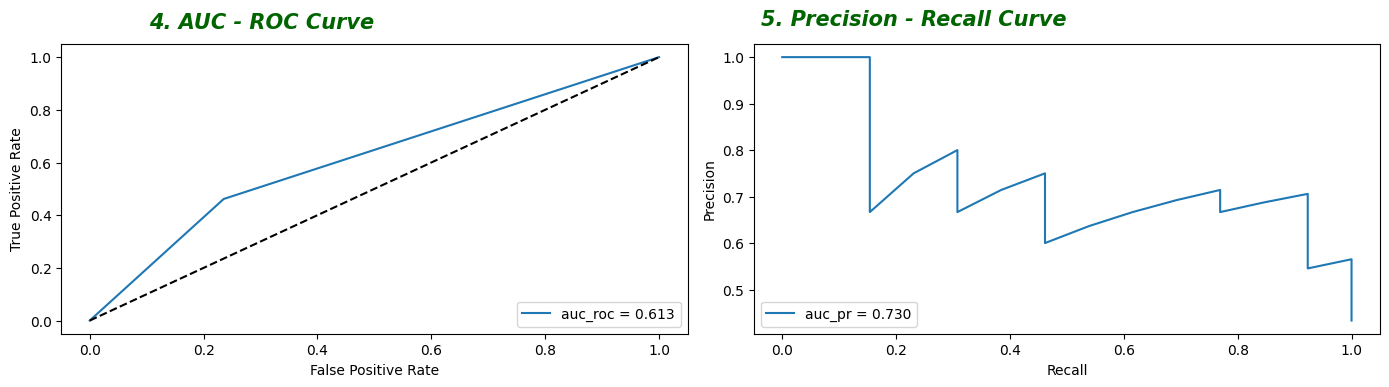

In [30]:
# LGBM with Best Hypertuned Parameters
best_lgb = lgb_grid.best_estimator_

best_lgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
Generate_Model_Test_Classification_Report(best_lgb, X_test, y_test, model_name="Tuned LGBM")

In [32]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create the neural network model
model_nn = Sequential()

model_nn.add(Dense(units=128, kernel_initializer='he_uniform', activation='relu', input_dim=3))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.5))

model_nn.add(Dense(units=256, kernel_initializer='he_uniform', activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.5))

model_nn.add(Dense(units=256, kernel_initializer='he_uniform', activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.5))

model_nn.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))

# Compile the model
model_nn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define an early stopping callback
early_stopping_nn = EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)

# Train the neural network
history_nn = model_nn.fit(X_train, y_train, batch_size=64, epochs=200, callbacks=[early_stopping_nn], validation_split=0.25)

# Evaluate the model on the test set
test_loss_nn, test_accuracy_nn = model_nn.evaluate(X_test, y_test)
print(f"Test Accuracy (Neural Network): {test_accuracy_nn}")


Epoch 1/200
5/5 [==============================] - 3s 91ms/step - loss: 0.9776 - accuracy: 0.5699 - val_loss: 0.9814 - val_accuracy: 0.4624
Epoch 2/200
5/5 [==============================] - 0s 17ms/step - loss: 1.0245 - accuracy: 0.5376 - val_loss: 0.8912 - val_accuracy: 0.5376
Epoch 3/200
5/5 [==============================] - 0s 18ms/step - loss: 0.9623 - accuracy: 0.5341 - val_loss: 0.8220 - val_accuracy: 0.5806
Epoch 4/200
5/5 [==============================] - 0s 22ms/step - loss: 1.0970 - accuracy: 0.4373 - val_loss: 0.7619 - val_accuracy: 0.5806
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 0.9221 - accuracy: 0.5520 - val_loss: 0.7129 - val_accuracy: 0.6559
Epoch 6/200
5/5 [==============================] - 0s 10ms/step - loss: 0.9300 - accuracy: 0.5341 - val_loss: 0.6706 - val_accuracy: 0.6774
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0494 - accuracy: 0.4910 - val_loss: 0.6370 - val_accuracy: 0.6989
Epoch 8/200
5/5 [===

In [35]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [33]:
def Generate_Model_Test_Classification_Report_NN(model, X_test, y_test, model_name=""):
    y = 1.05

    fig, axes = plt.subplots(3, 1, figsize=(8, 3))
    axes[0].text(9, 1.8, "CONSOLIDATED MODEL TEST REPORT", fontsize=30, horizontalalignment='center',
                color='DarkBlue', weight='bold')

    axes[0].axis([0, 10, 0, 10])
    axes[0].axis('off')

    axes[1].text(9, 4, "Model Name: " + model_name, style='italic',
                 fontsize=18, horizontalalignment='center', color='DarkOrange', weight='bold')

    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')

    axes[2].text(0, 4, "* 1 - Not Survived\t\t\t\t\t\t\t * 0 - Survived\n".expandtabs() +
                "* MCC - Matthews Correlation Coefficient\t\t* AUC - Area Under The Curve\n".expandtabs() +
                "* ROC - Receiver Operating Characteristics     " +
                "\t* AUROC - Area Under the Receiver Operating    Characteristics".expandtabs(),
                style='italic', fontsize=10, horizontalalignment='left', color='orangered')

    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')

    scores = []
    metrics = ['F1       ', 'MCC      ', 'Precision', 'Recall   ', 'Accuracy ',
               'AUC_ROC  ', 'AUC_PR   ']

    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_pred)
    precision, recall, th = precision_recall_curve(y_test.values.ravel(), y_pred)

    model_f1_score = f1_score(y_test, (y_pred > 0.5).astype(int))
    model_matthews_corrcoef_score = matthews_corrcoef(y_test, (y_pred > 0.5).astype(int))
    model_precision_score = precision_score(y_test, (y_pred > 0.5).astype(int))
    model_recall_score = recall_score(y_test, (y_pred > 0.5).astype(int))
    model_accuracy_score = accuracy_score(y_test, (y_pred > 0.5).astype(int))
    model_auc_roc = auc(fpr, tpr)
    model_auc_pr = auc(recall, precision)

    scores.append([model_f1_score,
                   model_matthews_corrcoef_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc,
                   model_auc_pr])

    sampling_results = pd.DataFrame(columns=['Classification Metric', 'Score Value'])
    for i in range(len(scores[0])):
        sampling_results.loc[i] = [metrics[i], scores[0][i]]

    sampling_results.index = np.arange(1, len(sampling_results) + 1)

    class_report = classification_report(y_test, (y_pred > 0.5).astype(int))
    conf_matx = confusion_matrix(y_test, (y_pred > 0.5).astype(int))

    fig, axes = plt.subplots(1, 3, figsize=(20, 4))  # Display the Confusion Matrix
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
    axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight='bold',
                      style='italic', loc='left', y=y)

    axes[1].text(5, 1.8, sampling_results.to_string(float_format='{:,.4f}'.format, index=False),
                 style='italic',  # Classification Metrics
                 fontsize=20, horizontalalignment='center')
    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')
    axes[1].set_title("2. Classification Metrics", fontsize=20, color='darkgreen', weight='bold',
                      style='italic', loc='center', y=y)

    axes[2].text(0, 1, class_report, style='italic', fontsize=20)  # Classification Report
    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')
    axes[2].set_title("3. Classification Report", fontsize=20, color='darkgreen', weight='bold',
                      style='italic', loc='center', y=y)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # AUC-ROC & Precision-Recall Curve

    axes[0].plot(fpr, tpr, label=f"auc_roc = {model_auc_roc:.3f}")
    axes[1].plot(recall, precision, label=f"auc_pr = {model_auc_pr:.3f}")

    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].legend(loc="lower right")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("4. AUC - ROC Curve", fontsize=15, color='darkgreen', ha='right', weight='bold',
                      style='italic', loc='center', pad=1, y=y)

    axes[1].legend(loc="lower left")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("5. Precision - Recall Curve", fontsize=15, color='darkgreen', ha='right', weight='bold',
                      style='italic', loc='center', pad=3, y=y)

    plt.subplots_adjust(top=0.95)
    plt.tight_layout()
    plt.show()

    return None


1/1 [==============================] - 0s 187ms/step


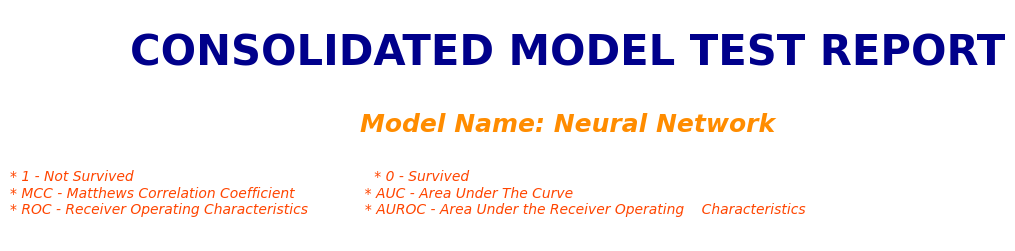

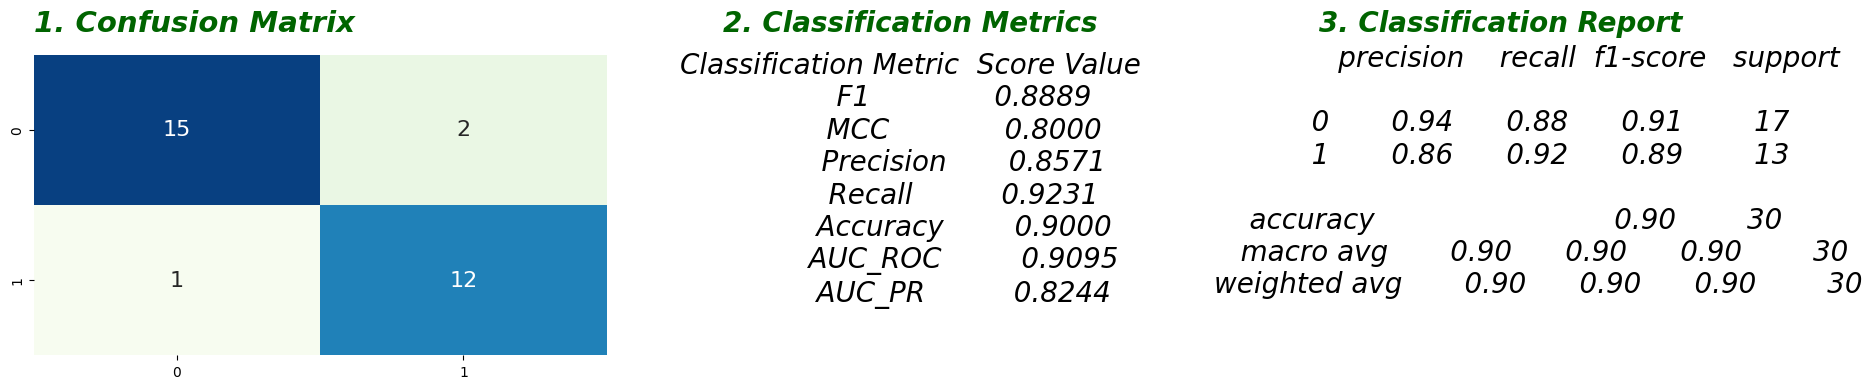

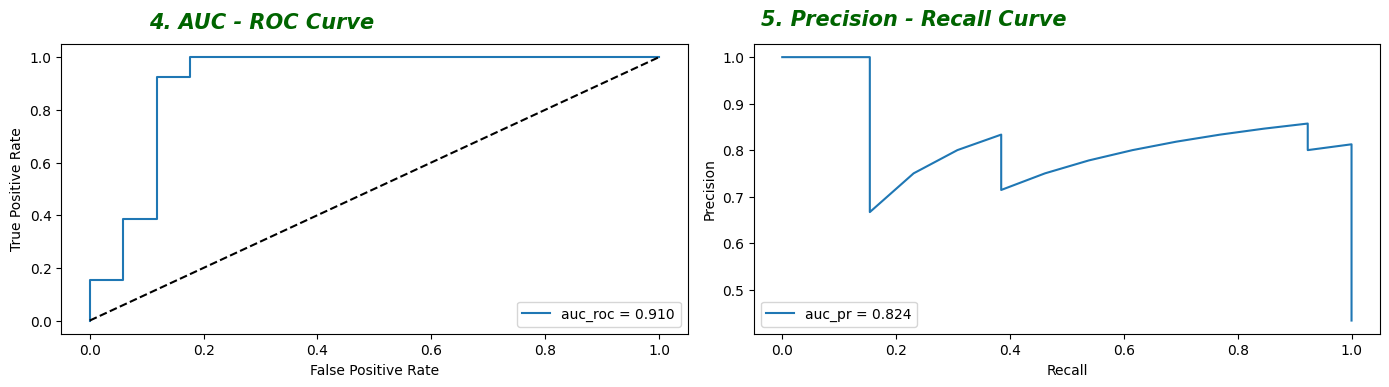

In [34]:
# Assuming your neural network model is stored in model_nn
Generate_Model_Test_Classification_Report_NN(model_nn, X_test, y_test, model_name="Neural Network")
